In [37]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))

In [261]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import pickle
import torch
from sklearn.metrics import auc
from skimage.exposure import equalize_hist
from matplotlib import rcParams
rcParams.update({'font.size': 16})

pd.options.display.float_format = '{:.4f}'.format

# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 18})
# rc('text', usetex=True)

np.random.seed(42)

# Globals

In [39]:
# Load image and mask data
with open("/hdd0/projects/regex/evals/images_and_masks.pkl", 'rb') as f:
    images_and_masks = pickle.load(f)
methods = ["IoU (q=0.1)", "IoU (q=0.05)", "IoU (q=0.025)", "mAP"]
result_index = ["k", "method", "level", "metric", "value"]
mri_modality = 2

# Test random attributions

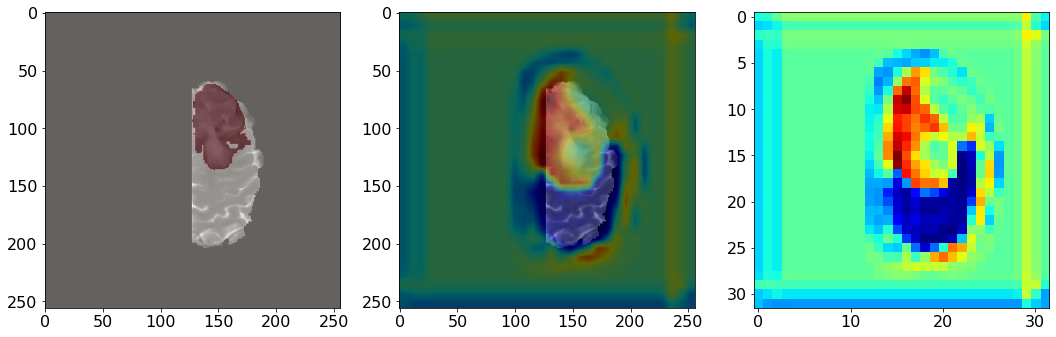

In [43]:
with open("/hdd0/projects/regex/evals/ensemble_attrs/k=3_tau4_attrs_level=4.pkl", 'rb') as f:
    attrs = pickle.load(f)
idx = np.random.randint(0, len(images_and_masks))
idx = 455
# print(idx)
fig, ax = plt.subplots(1, 3, figsize=(18,10))
image, label, mask = images_and_masks[idx]
ax[0].imshow(image[mri_modality], cmap="gray")
ax[0].imshow(mask, cmap="Reds", alpha=0.4)
ax[1].imshow(image[mri_modality], cmap="gray")
ax[1].imshow(cv2.resize(attrs[idx][0].numpy(), (256,256)), cmap="jet", alpha=0.4)
ax[2].imshow(attrs[idx][0], cmap="jet")

# Load data

In [239]:
result_dir = "/hdd0/projects/regex/evals/ensemble_results"
results = os.listdir(result_dir)
result_df = pd.DataFrame(columns=result_index)
for result in results:
    k, method, level, metric = re.search(r"k=([0-9]+)_method=([^\_]+)_level=([0-9]+)__(.+).pkl", result).groups()
    with open(os.path.join(result_dir, result), 'rb') as f:
        value = pickle.load(f)
        result_df = result_df.append({"k": k, "method": method, "level": level, "metric": metric, "value": value}, ignore_index=True)
result_df = result_df[result_df['method'] != "InputXGradients"]
result_df = result_df.replace("ViT", "ViT-B/16")
result_df = result_df.replace("Baseline", "Unconstrained")
result_df = result_df.replace("Solver", "CVX")

In [240]:
result_df.groupby(["method", "metric", "level"], as_index=False).mean()

,method,metric,level,value
0,CVX,map,3,0.3438
1,CVX,qiou_q=0.025,3,0.1994
2,CVX,qiou_q=0.05,3,0.2466
3,CVX,qiou_q=0.1,3,0.2323
4,DeepLIFT,map,3,0.4940
5,DeepLIFT,map,4,0.5566
6,DeepLIFT,qiou_q=0.025,3,0.3518
7,DeepLIFT,qiou_q=0.025,4,0.4024
8,DeepLIFT,qiou_q=0.05,3,0.2920
9,DeepLIFT,qiou_q=0.05,4,0.3338


In [241]:
t1 = result_df.groupby(["method", "metric", "level"], as_index=False).mean().pivot(index=['level', 'metric'], columns=['method'], values=['value']) * 100
t1 = t1.applymap(lambda x: f"{x:.2f}")
t1.columns = [col[1] for col in t1.columns]
t1 = t1[["DeepLIFT", "LRP", "GradCAM", "ViT-B/16", "Tau3", "Tau4", "Unconstrained", "CVX", "Marginal"]]
t1

DeepLIFT    LRP GradCAM ViT-B/16   Tau3   Tau4  \
level metric                                                        
3     map             49.40  35.61   58.68    52.40  33.03    nan   
      qiou_q=0.025    35.18  25.12   31.59    26.63  18.19    nan   
      qiou_q=0.05     29.20  22.03   39.34    34.28  25.79    nan   
      qiou_q=0.1      18.78  15.18   34.20    32.95  23.25    nan   
4     map             55.66  39.58   45.04    52.40    nan  34.17   
      qiou_q=0.025    40.24  27.51   23.78    26.63    nan  17.88   
      qiou_q=0.05     33.38  23.51   31.87    34.28    nan  24.20   
      qiou_q=0.1      20.93  16.10   29.41    32.95    nan  23.89   

                   Unconstrained    CVX Marginal  
level metric                                      
3     map                  19.01  34.38    71.82  
      qiou_q=0.025          9.89  19.94    45.23  
      qiou_q=0.05          13.82  24.66    48.59  
      qiou_q=0.1           14.32  23.23    32.75  
4     map                  41.44    nan    76.16  
      qiou_q=0.025         23.65    nan    46.17  
      qiou_q=0.05          29.19    nan    51.29  
      qiou_q=0.1           26.09    nan    34.64

In [242]:
t2 = result_df.groupby(["method", "metric", "level"], as_index=False).std().pivot(index=['level', 'metric'], columns=['method'], values=['value']) * 100
t2 = t2.applymap(lambda x: f"{x:.2f}")
t2.columns = [col[1] for col in t2.columns]
t2 = t2[["DeepLIFT", "LRP", "GradCAM", "ViT-B/16", "Tau3", "Tau4", "Unconstrained", "CVX", "Marginal"]]
t2

DeepLIFT  LRP GradCAM ViT-B/16   Tau3  Tau4 Unconstrained  \
level metric                                                                   
3     map               nan  nan     nan     4.18  11.46   nan         12.33   
      qiou_q=0.025      nan  nan     nan     3.20   8.19   nan          8.58   
      qiou_q=0.05       nan  nan     nan     2.51   7.18   nan         11.12   
      qiou_q=0.1        nan  nan     nan     0.94   4.68   nan          8.43   
4     map               nan  nan     nan     4.18    nan  9.02         10.01   
      qiou_q=0.025      nan  nan     nan     3.20    nan  4.95          5.55   
      qiou_q=0.05       nan  nan     nan     2.51    nan  5.28          5.64   
      qiou_q=0.1        nan  nan     nan     0.94    nan  4.26          4.07   

                      CVX Marginal  
level metric                        
3     map           14.03     4.25  
      qiou_q=0.025   8.65     2.07  
      qiou_q=0.05   10.58     2.92  
      qiou_q=0.1     6.12     2.37  
4     map             nan     3.80  
      qiou_q=0.025    nan     1.74  
      qiou_q=0.05     nan     2.76  
      qiou_q=0.1      nan     2.08

In [64]:
print((t1 + "+/-" + t2).to_latex())

\begin{tabular}{llllllllll}
\toprule
  &            &     DeepLIFT &          LRP &      GradCAM &      ViT-B/16 &           Tau3 &          Tau4 &  Unconstrained &      Marginal \\
level & metric &              &              &              &               &                &               &                &               \\
\midrule
3 & map &  49.40+/-nan &  35.61+/-nan &  58.68+/-nan &  52.40+/-4.18 &  33.03+/-11.46 &     nan+/-nan &  19.01+/-12.33 &  71.82+/-4.25 \\
  & qiou\_q=0.025 &  35.18+/-nan &  25.12+/-nan &  31.59+/-nan &  26.63+/-3.20 &   18.19+/-8.19 &     nan+/-nan &    9.89+/-8.58 &  45.23+/-2.07 \\
  & qiou\_q=0.05 &  29.20+/-nan &  22.03+/-nan &  39.34+/-nan &  34.28+/-2.51 &   25.79+/-7.18 &     nan+/-nan &  13.82+/-11.12 &  48.59+/-2.92 \\
  & qiou\_q=0.1 &  18.78+/-nan &  15.18+/-nan &  34.20+/-nan &  32.95+/-0.94 &   23.25+/-4.68 &     nan+/-nan &   14.32+/-8.43 &  32.75+/-2.37 \\
4 & map &  55.66+/-nan &  39.58+/-nan &  45.04+/-nan &  52.40+/-4.18 &      nan+/-nan

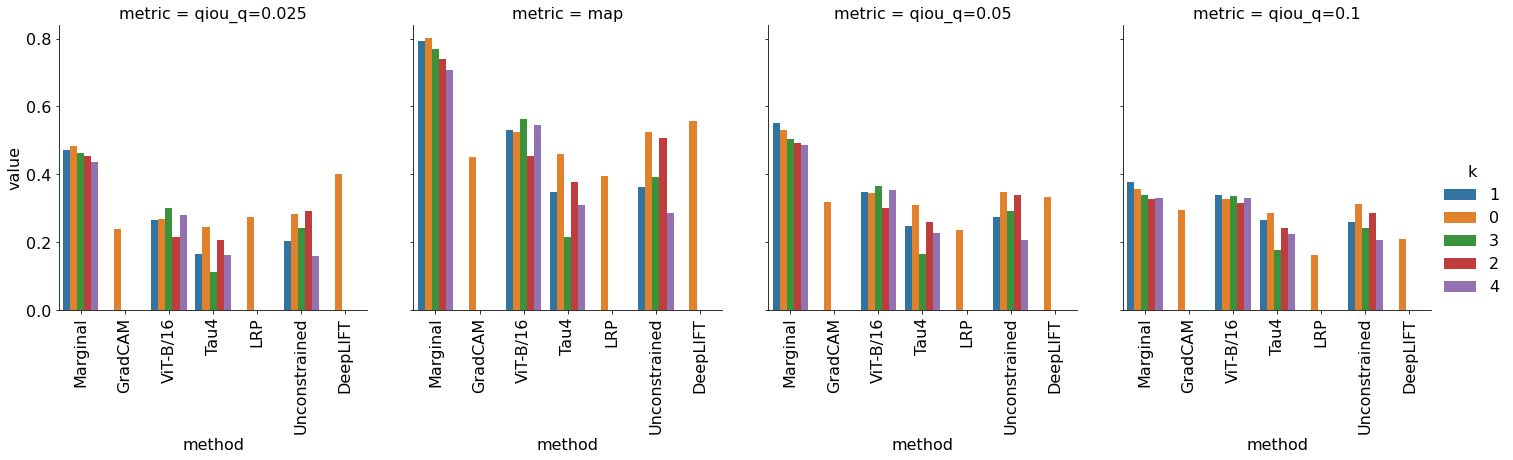

In [66]:
df3 = result_df[result_df['level'] == '4']
g = sns.catplot(x="method", y="value",
                hue="k", col="metric",
                data=df3, kind="bar")
g.set_xticklabels(rotation=90)

In [464]:
result_df.groupby(['method', "level", "metric"]).mean()

value
method          level metric             
Baseline        3     map          0.1901
                      qiou_q=0.025 0.0989
                      qiou_q=0.05  0.1382
                      qiou_q=0.1   0.1432
                4     map          0.4144
                      qiou_q=0.025 0.2365
                      qiou_q=0.05  0.2919
                      qiou_q=0.1   0.2609
DeepLIFT        3     map          0.4940
                      qiou_q=0.025 0.3518
                      qiou_q=0.05  0.2920
                      qiou_q=0.1   0.1878
                4     map          0.5566
                      qiou_q=0.025 0.4024
                      qiou_q=0.05  0.3338
                      qiou_q=0.1   0.2093
GradCAM         3     map          0.5868
                      qiou_q=0.025 0.3159
                      qiou_q=0.05  0.3934
                      qiou_q=0.1   0.3420
                4     map          0.4504
                      qiou_q=0.025 0.2378
                      qiou_q=0.05  0.3187
                      qiou_q=0.1   0.2941
InputXGradients 3     map          0.3561
                      qiou_q=0.025 0.2512
                      qiou_q=0.05  0.2203
                      qiou_q=0.1   0.1518
                4     map          0.3958
                      qiou_q=0.025 0.2751
                      qiou_q=0.05  0.2351
                      qiou_q=0.1   0.1610
LRP             3     map          0.3561
                      qiou_q=0.025 0.2512
                      qiou_q=0.05  0.2203
                      qiou_q=0.1   0.1518
                4     map          0.3958
                      qiou_q=0.025 0.2751
                      qiou_q=0.05  0.2351
                      qiou_q=0.1   0.1610
Marginal        3     map          0.7182
                      qiou_q=0.025 0.4523
                      qiou_q=0.05  0.4859
                      qiou_q=0.1   0.3275
                4     map          0.7616
                      qiou_q=0.025 0.4617
                      qiou_q=0.05  0.5129
                      qiou_q=0.1   0.3464
ViT             3     map          0.5240
                      qiou_q=0.025 0.2663
                      qiou_q=0.05  0.3428
                      qiou_q=0.1   0.3295
                4     map          0.5240
                      qiou_q=0.025 0.2663
                      qiou_q=0.05  0.3428
                      qiou_q=0.1   0.3295

In [465]:
result_df.groupby(['method', "level", "metric"]).std()

value
method          level metric             
Baseline        3     map          0.1233
                      qiou_q=0.025 0.0858
                      qiou_q=0.05  0.1112
                      qiou_q=0.1   0.0843
                4     map          0.1001
                      qiou_q=0.025 0.0555
                      qiou_q=0.05  0.0564
                      qiou_q=0.1   0.0407
DeepLIFT        3     map             NaN
                      qiou_q=0.025    NaN
                      qiou_q=0.05     NaN
                      qiou_q=0.1      NaN
                4     map             NaN
                      qiou_q=0.025    NaN
                      qiou_q=0.05     NaN
                      qiou_q=0.1      NaN
GradCAM         3     map             NaN
                      qiou_q=0.025    NaN
                      qiou_q=0.05     NaN
                      qiou_q=0.1      NaN
                4     map             NaN
                      qiou_q=0.025    NaN
                      qiou_q=0.05     NaN
                      qiou_q=0.1      NaN
InputXGradients 3     map             NaN
                      qiou_q=0.025    NaN
                      qiou_q=0.05     NaN
                      qiou_q=0.1      NaN
                4     map             NaN
                      qiou_q=0.025    NaN
                      qiou_q=0.05     NaN
                      qiou_q=0.1      NaN
LRP             3     map             NaN
                      qiou_q=0.025    NaN
                      qiou_q=0.05     NaN
                      qiou_q=0.1      NaN
                4     map             NaN
                      qiou_q=0.025    NaN
                      qiou_q=0.05     NaN
                      qiou_q=0.1      NaN
Marginal        3     map          0.0425
                      qiou_q=0.025 0.0207
                      qiou_q=0.05  0.0292
                      qiou_q=0.1   0.0237
                4     map          0.0380
                      qiou_q=0.025 0.0174
                      qiou_q=0.05  0.0276
                      qiou_q=0.1   0.0208
ViT             3     map          0.0418
                      qiou_q=0.025 0.0320
                      qiou_q=0.05  0.0251
                      qiou_q=0.1   0.0094
                4     map          0.0418
                      qiou_q=0.025 0.0320
                      qiou_q=0.05  0.0251
                      qiou_q=0.1   0.0094

# Table

In [466]:
results_file = f"/hdd0/projects/regex/evals/segmentation_results_level=1.pkl"
with open(results_file, 'rb') as f:
    results_dict = pickle.load(f)
results1 = pd.DataFrame(results_dict, index=methods)
# results1.pop("Solver Attention")
results1*100

,GradCAM,InputXGradients,DeepLIFT,LRP,Baseline Attention,Solver Attention,Marginal Attention
IoU (q=0.1),43.8117,15.0038,13.6920,15.0037,29.3393,NaN,32.5108
IoU (q=0.05),53.5685,22.3416,19.5722,22.3417,31.1839,NaN,36.1135
IoU (q=0.025),44.0742,25.0000,23.0331,25.0001,24.1195,NaN,26.6739
mAP,73.8317,34.0931,32.0943,34.0931,45.4961,NaN,49.0756


In [467]:
results_file = f"/hdd0/projects/regex/evals/segmentation_results_level=2.pkl"
with open(results_file, 'rb') as f:
    results_dict = pickle.load(f)
results2 = pd.DataFrame(results_dict, index=methods) * 100
results2
# results2.pop("Solver Attention")

,GradCAM,InputXGradients,DeepLIFT,LRP,Baseline Attention,Solver Attention,Marginal Attention
IoU (q=0.1),40.5246,15.1021,16.6705,15.1022,38.8297,NaN,38.3004
IoU (q=0.05),57.4052,22.6667,23.5133,22.6667,50.1748,NaN,48.1837
IoU (q=0.025),51.1394,25.6600,26.2906,25.6600,40.7849,NaN,38.7390
mAP,85.1989,35.3275,37.5598,35.3275,71.3383,NaN,68.0304


In [468]:
results_file = f"/hdd0/projects/regex/evals/segmentation_results_level=3.pkl"
with open(results_file, 'rb') as f:
    results_dict = pickle.load(f)
results3 = pd.DataFrame(results_dict, index=methods) * 100
results3

,GradCAM,InputXGradients,DeepLIFT,LRP,ViT Attention,Baseline Attention,Solver Attention,Marginal Attention
IoU (q=0.1),35.9499,15.1263,18.2190,15.1268,30.9092,17.1110,32.5945,41.4097
IoU (q=0.05),49.0747,22.8821,26.2180,22.8820,31.9303,16.7567,40.5342,52.4637
IoU (q=0.025),46.5844,26.7227,29.3259,26.7224,23.6646,13.6288,34.1169,46.0737
mAP,74.6024,37.1766,42.5032,37.1766,46.9140,16.6128,58.9297,78.3137


In [469]:
results_file = f"/hdd0/projects/regex/evals/segmentation_results_level=4.pkl"
with open(results_file, 'rb') as f:
    results_dict = pickle.load(f)
results4 = pd.DataFrame(results_dict, index=methods) * 100
results4
# results2.pop("Solver Attention")

,GradCAM,InputXGradients,DeepLIFT,LRP,ViT Attention,Baseline Attention,Solver Attention,Marginal Attention
IoU (q=0.1),11.3309,15.5529,20.3927,15.5517,30.9092,36.2398,NaN,36.5617
IoU (q=0.05),18.2344,23.6133,29.9802,23.6135,31.9303,42.8059,NaN,48.6475
IoU (q=0.025),25.9524,28.1170,32.9465,28.1176,23.6646,36.0887,NaN,43.1514
mAP,31.7551,39.2093,47.9463,39.2094,46.9140,66.0323,NaN,74.8462


## Level 3 segmentation

In [470]:
results3.transpose()

,IoU (q=0.1),IoU (q=0.05),IoU (q=0.025),mAP
GradCAM,35.9499,49.0747,46.5844,74.6024
InputXGradients,15.1263,22.8821,26.7227,37.1766
DeepLIFT,18.2190,26.2180,29.3259,42.5032
LRP,15.1268,22.8820,26.7224,37.1766
ViT Attention,30.9092,31.9303,23.6646,46.9140
Baseline Attention,17.1110,16.7567,13.6288,16.6128
Solver Attention,32.5945,40.5342,34.1169,58.9297
Marginal Attention,41.4097,52.4637,46.0737,78.3137


In [471]:
print(results3.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  GradCAM &  InputXGradients &  DeepLIFT &     LRP &  ViT Attention &  Baseline Attention &  Solver Attention &  Marginal Attention \\
\midrule
IoU (q=0.1)   &  35.9499 &          15.1263 &   18.2190 & 15.1268 &        30.9092 &             17.1110 &           32.5945 &             41.4097 \\
IoU (q=0.05)  &  49.0747 &          22.8821 &   26.2180 & 22.8820 &        31.9303 &             16.7567 &           40.5342 &             52.4637 \\
IoU (q=0.025) &  46.5844 &          26.7227 &   29.3259 & 26.7224 &        23.6646 &             13.6288 &           34.1169 &             46.0737 \\
mAP           &  74.6024 &          37.1766 &   42.5032 & 37.1766 &        46.9140 &             16.6128 &           58.9297 &             78.3137 \\
\bottomrule
\end{tabular}



In [472]:
results_file = f"/hdd0/projects/regex/evals/segmentation_results_level=4.pkl"
with open(results_file, 'rb') as f:
    results_dict = pickle.load(f)
results4 = pd.DataFrame(results_dict, index=methods) * 100

## Level 4 segmentation

In [473]:
results4

,GradCAM,InputXGradients,DeepLIFT,LRP,ViT Attention,Baseline Attention,Solver Attention,Marginal Attention
IoU (q=0.1),11.3309,15.5529,20.3927,15.5517,30.9092,36.2398,NaN,36.5617
IoU (q=0.05),18.2344,23.6133,29.9802,23.6135,31.9303,42.8059,NaN,48.6475
IoU (q=0.025),25.9524,28.1170,32.9465,28.1176,23.6646,36.0887,NaN,43.1514
mAP,31.7551,39.2093,47.9463,39.2094,46.9140,66.0323,NaN,74.8462


In [474]:
print(results4.to_latex())

\begin{tabular}{lrrrrrrlr}
\toprule
{} &  GradCAM &  InputXGradients &  DeepLIFT &     LRP &  ViT Attention &  Baseline Attention & Solver Attention &  Marginal Attention \\
\midrule
IoU (q=0.1)   &  11.3309 &          15.5529 &   20.3927 & 15.5517 &        30.9092 &             36.2398 &              NaN &             36.5617 \\
IoU (q=0.05)  &  18.2344 &          23.6133 &   29.9802 & 23.6135 &        31.9303 &             42.8059 &              NaN &             48.6475 \\
IoU (q=0.025) &  25.9524 &          28.1170 &   32.9465 & 28.1176 &        23.6646 &             36.0887 &              NaN &             43.1514 \\
mAP           &  31.7551 &          39.2093 &   47.9463 & 39.2094 &        46.9140 &             66.0323 &              NaN &             74.8462 \\
\bottomrule
\end{tabular}



In [475]:
pd.MultiIndex.from_frame(results4)

MultiIndex([(11.330933988097739, 15.552943601779177, 20.392698359956807, ...),
            (18.234379417574516,  23.61326760887862, 29.980217578497857, ...),
            ( 25.95239315148619, 28.116972887996607,  32.94651971367122, ...),
            (31.755127198636895,  39.20930917639272,   47.9463297775212, ...)],
           names=['GradCAM', 'InputXGradients', 'DeepLIFT', 'LRP', 'ViT Attention', 'Baseline Attention', 'Solver Attention', 'Marginal Attention'])

# Images with heatmaps

In [255]:
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize
from torchvision.transforms import InterpolationMode
from kornia.augmentation import Normalize
from dataio.dataloader import probe_data_folder, BraTS18Binary
    
# Load attribution data
level = 3
method_names = [
    ("DeepLIFT", "/hdd0/projects/regex/evals/ensemble_attrs/k=0_dl_attrs_level=3.pkl", "/hdd0/projects/regex/evals/ensemble_attrs/k=0_dl_attrs_level=4.pkl"),
    ("LRP", "/hdd0/projects/regex/evals/ensemble_attrs/k=0_lrp_attrs_level=3.pkl", "/hdd0/projects/regex/evals/ensemble_attrs/k=0_lrp_attrs_level=4.pkl"),
    ("GradCAM", "/hdd0/projects/regex/evals/ensemble_attrs/k=0_gc_attrs_level=3.pkl", "/hdd0/projects/regex/evals/ensemble_attrs/k=0_gc_attrs_level=4.pkl"),
    ("ViT-B/16", "/hdd0/projects/regex/evals/ensemble_attrs/k=1_vit_attrs_level=3.pkl", "/hdd0/projects/regex/evals/ensemble_attrs/k=1_vit_attrs_level=4.pkl"),
    (r"$\tau^k$", "/hdd0/projects/regex/evals/ensemble_attrs/k=0_tau3_attrs_level=3.pkl", "/hdd0/projects/regex/evals/ensemble_attrs/k=0_tau3_attrs_level=3.pkl"),
    (r"$\tau^l$", "/hdd0/projects/regex/evals/ensemble_attrs/k=0_tau4_attrs_level=4.pkl", "/hdd0/projects/regex/evals/ensemble_attrs/k=0_tau4_attrs_level=4.pkl"),
    ("Unconst.", "/hdd0/projects/regex/evals/ensemble_attrs/k=1_baseline_attrs_level=3.pkl", "/hdd0/projects/regex/evals/ensemble_attrs/k=1_baseline_attrs_level=4.pkl"),
    ("CVX", "/hdd0/projects/regex/evals/ensemble_attrs/k=1_solver_attrs_level=3.pkl", "/hdd0/projects/regex/evals/ensemble_attrs/k=1_solver_attrs_level=3.pkl"),
    ("Dual (Ours)", "/hdd0/projects/regex/evals/ensemble_attrs/k=1_marginal_attrs_level=3.pkl", "/hdd0/projects/regex/evals/ensemble_attrs/k=1_marginal_attrs_level=4.pkl"),
]

methods = []
for name, filename3, filename4 in method_names:
    with open(filename3, 'rb') as f:
        file3 = pickle.load(f)
    with open(filename4, 'rb') as f:
        file4 = pickle.load(f)
    methods.append((name, file3, file4))
# results.pop("Solver Attention")

In [256]:
# samples = np.random.randint(0, high=len(images_and_masks), size=5)
# samples = [1899, 1297, 2062, 1955, 870, 161, 502, 763, 1367, 2088]
samples = [900]
print(samples)

[900]


In [257]:
def hnorm(t, eq_hist=True):
    t -= t.min()
    t /= t.max()
#     t *= 255
#     t = t.astype(np.uint8)
    if eq_hist:
        t = equalize_hist(t, nbins=2048, mask=None)
    return t

<ipython-input-263-340fb5ce8ac3>:50: UserWarning: No contour levels were found within the data range.
  mri_ax.contour(np.arange(mask.shape[0]), np.arange(mask.shape[1]), mask, 0, linewidths=2, colors=["red"])


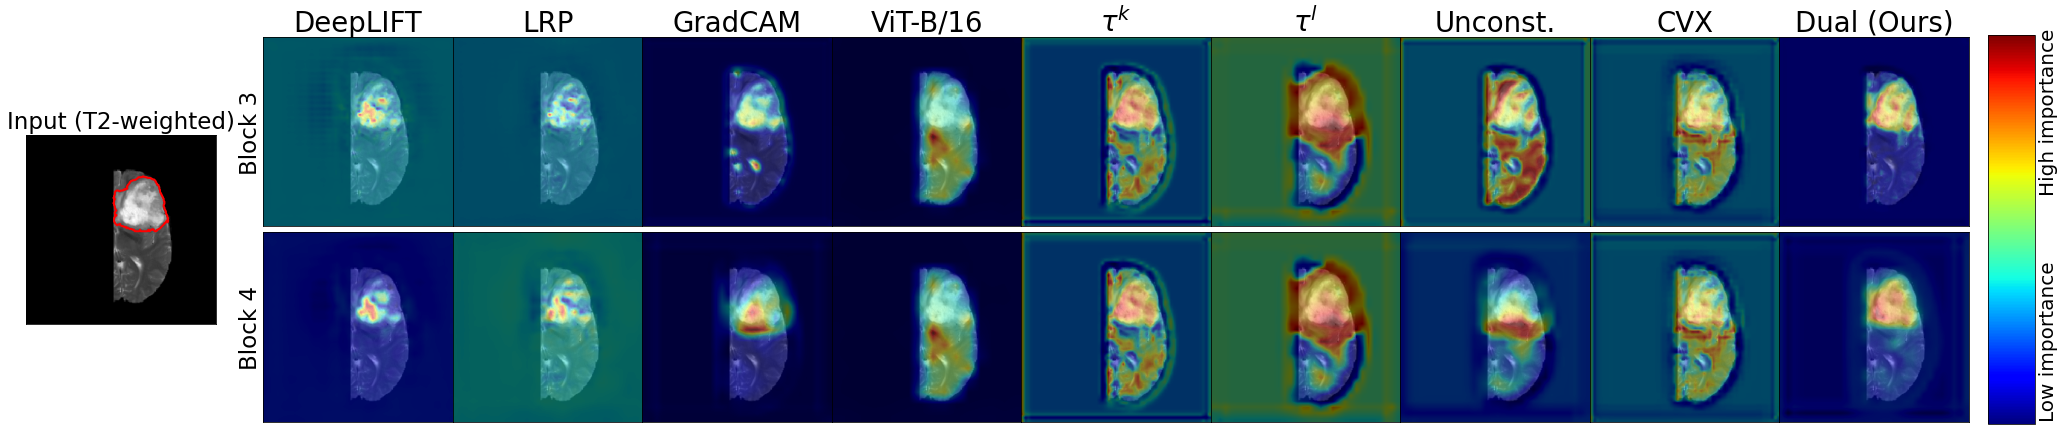

In [263]:
row_size = 2*3*len(samples)
row_len = 2*len(samples)
col_size = 3*len(methods)+4
col_len = len(methods)+4
fig = plt.figure(figsize=(col_size, row_size))
gs = gridspec.GridSpec(nrows=row_len, 
                       ncols=col_len, 
                       left=0.05, 
                       bottom=0.05, 
                       right=0.95, 
                       top=0.95, 
                       wspace=0.0, 
                       hspace=0.01,
                       width_ratios=[1, 0.25, *list([1 for i in methods]), 0.1, 0.25])


# Set mri image col
mri_col = []
i = 0
for _ in range(len(samples)):
    ax = plt.subplot(gs[i:i+2, 0])
    mri_col.append(ax)
    i += 2

# Set blank image col
blank_col = []
for i in range(2*len(samples)):
    ax = plt.subplot(gs[i, 1])
    blank_col.append(ax)

# Set colobar col
colorbar_col = []
for i in range(len(samples)):
    ax = plt.subplot(gs[i:i+2, col_len-1])
    colorbar_col.append(ax)

# Set attributions matrix
matrix = []
for i in range(2*len(samples)):
    row = []
    for j in range(len(methods)):
        ax = plt.subplot(gs[i, j+2])
        row.append(ax)
    matrix.append(row)

# Plot mri images
for mri_ax, sample_idx in zip(mri_col, samples):
    image, label, mask = images_and_masks[sample_idx]
    mri_ax.imshow(image[mri_modality], cmap="gray")
    mri_ax.contour(np.arange(mask.shape[0]), np.arange(mask.shape[1]), mask, 0, linewidths=2, colors=["red"])

# Plot attribution
running_idx = 0
for i in range(0, 2*len(samples), 2):
    idx = samples[running_idx]
    image, label, mask = images_and_masks[idx]
    for j in range(len(methods)):
        attr3 = methods[j][1][idx][0].numpy()
#         attr3 = hnorm(attr3)
        attr3 = cv2.resize(attr3, (256, 256), interpolation=cv2.INTER_LINEAR)
        attr4 = methods[j][2][idx][0].numpy()
#         attr4 = hnorm(attr4)
        attr4 = cv2.resize(attr4, (256, 256), interpolation=cv2.INTER_LINEAR)
        matrix[i][j].imshow(image[mri_modality], cmap="gray")
        matrix[i][j].imshow(attr3, cmap="jet", alpha=0.4)
        matrix[i+1][j].imshow(image[mri_modality], cmap="gray")
        matrix[i+1][j].imshow(attr4, cmap="jet", alpha=0.4)
    running_idx += 1

# Plot colorbars
normalizer = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)
mappable = matplotlib.cm.ScalarMappable(norm=normalizer, cmap="jet")
for i, colorbar_ax in enumerate(colorbar_col):
    cbar = matplotlib.pyplot.colorbar(mappable=mappable, cax=colorbar_ax, ticks=[0.4, 1.0], shrink=0.9)
    cbar.ax.set_yticklabels(['Low importance', 'High importance'], rotation=90)
    cbar.ax.tick_params(axis=u'both', which=u'both', length=0, labelsize=20)
    
# Set titles
mri_col[0].set_title(f"Input (T2-weighted)", fontsize="x-large")
for j, ax in enumerate(matrix[0]):
    ax.set_title(methods[j][0], fontsize="xx-large")
    
for i, row in enumerate(matrix):
    if i % 2 == 0:
        row[0].set_ylabel("Block 3", labelpad=-2, fontsize="x-large")
    else:
        row[0].set_ylabel("Block 4", labelpad=-2, fontsize="x-large")
        
for ax in mri_col:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', length=0)
    
for ax in blank_col:
    ax.axis("off")
    
for row in matrix:
    for ax in row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(axis='both', which='both', length=0)